In [ ]:
import marimo as mo

# Market Data Simulator

## Tech Stack

- Java, Spring Boot, Spring WebFlux, Google Guava (cache), Gradle, JUnit, Mockito, VS Code

## Assumptions

1. I will assume that the simulator will be used by a small number of clients (e.g. >= 0, <= 20). Replay sessions for a small number of clients can be handled on a single server using native Java threads (or threadpool). For a greater number of clients on a single server, virtual threads would work well but they are not quite production grade in Java 17. In any case, one could always spin up additional replay servers along with a load balancer to fan out sessions among servers
  - [sree] ok

2. I will assume that CSV file contents can fit into replay process memory (all data is cached)
  - [sree] ok

3. I will assume that simple streaming of data - e.g. server side events or other streaming strategy - is adequate (instead of using pub/sub to offload streaming responsibility to a message broker)
  -[ sree] correct

4. I will assume that a replay session that is interrupted midstream will not require automatic session reconnect/restart capability
  - [sree] correct

5. There will be two 'clocks' - a Replay clock and a Simulation clock. The Replay clock (per session) will control the frequency (how often) of data publication to a replay session. The Simulation clock (also per session) will control the quantity (how much) data is published to a replay session
  - [sree] ok. Had to read the next 2 to understand this. So your ‘Replay clock’ specifies the publishing cadence. Yes, that works.

6. Replay clock granularity will be 1 second (might be configurable) - i.e. data events will be published to each session at 1 second intervals
  - [sree]  1 sec would likely need some buffering and smoothening out by the UI. Try for an approach that does not require UI to buffer/smooth out. Assume a reasonably powerful server for your app, and the limited number of clients that you noted above to keep the design simple.

7. Simulation clock granularity will be governed by the replay rate (default: 1.0, may be changed by client). For example, a replay rate of 1.0 would advance the simulation
clock in lockstep with the replay clock. And a replay rate of 1.5 would advance the simulation clock at 1.5X the Replay rate - e.g. each time the replay clock advances by 1 second (1000 milliseconds), the simulation clock will advance by 1.5 seconds (1500 millisecs)
  - [sree] yes. Support both speed up and slow down.

8. During each publishing interval (see 6) all unpublished events within the session simulation clock window will be published
  - [sree] ok

9. Data will be published as JSON (CSV row data -> Record -> JSON conversion done on replay server)
  - [sree] ok

10. Security (Https) and authentication out of scope

## Requirements

### Functional

1. Stream market data events to Web clients.
2. Allow multiple clients - i.e. mujst support concurrent replay sessions.
3. Clients should be able to control replay sessions by sending the following commands:
    - **Create** replay session.
    - **Start** & **Stop** session.
    - **Rewind** session - i.e. rewind to beginning of market data event stream.
    - **Set replay speed** - i.e. **speed up** replay to N, where $N \gt 1.0$. **Slow down** replay to M where $0.0 \lt M \lt 1.0$.
    - **Fast forward** replay session - i.e. skip **N** market data events in replay session, where $N \gt 0$. Forwarding past event stream stops the replay session.
    - **Goto event** - i.e. jump to specific market data event (by event ID) in replay session.

### Non-Functional

1. **Performance**
    - **Throughput** -  replay at sustained high throughput (up to 3000 events/sec).
    - **Scale** - support large number of clients [0, 100] without performance degradation.
   - **Stability**
2. **Design Quality** - design should be easy to understand and to update.
3. **Code Quality** - code should be production quality with good documentation.
4. **Testing** - implementation should be easily testable, congtain test scaffolding, and performance claims should be backed by evidence.

## Design decisions

- **Spring Boot application** with **RESTful APIs** for replay controls.
- **Reactive SpringFlux** application for streaming market data events.
- **Data** -> read from [CSV file](https://github.com/himalayahall/demo/blob/9f346eac082b2ba9300041759bce3413532ba7fa/src/main/resources/marketdata-for-coding-challenge.csv). FYI - file had invisible BOM (invisible byte-order mark) which caused a lot of head scratching before I pinpointed the cause and fixed it (see below).
- **Session cache** - sessions are stored in Google Guava cache, **stale** sessions are ejected after a configurable timeout in `application.properties`. Default cache cofiguration is `1 HOUR`.
- **Sliding window** -> virtual sliding window moves over cached events, during each publishing cycle ALL events under sliding window are published. Sliding window and event publication controls are set through `application.properties`:

    - **publishTimerMillis** -  controls how often the sliding window is moved, default: `1 millisecond`.
    - **replayClockMillis** - tracks progress of time in replay session; controls the sliding window size. When a session is `created` or `rewound`, the `replayClockMillis` is initialized to timestamp of the first data event. At each publishing cycle all `unpublished` events with $timestamp \leq replayClockMillis$ are published and then `replayClockMillis` is set to $replayClockMillis + (replaySpeed \times publishTimerMillis$).

  - **replaySpeed** - controls how fast the replay clock advances. For example, suppose  $publishTimerMillis =  1$ and $replaySpeed = 1.0$. During each publishing cycle `replayClockMillis` will advance by $replaySpeed \times publishTimerMillis$.

    Suppose `replaySpeed` is bumped up to `2.0`. During each subsequent publishing cycle, `replayClockMillis` will advance  $2.0 \times publishTimerMillis$ milliseconds. For example, with default replay settings,  `replayClockMillis` will advance `2 milliseconds` for each `1 millisecond` advance of the system clock. This works both for speeding up ($replaySpeed \gt 1.0$) and slowing down ($replaySpeed \lt 1.0)$ replay.

  - Automated performance testing - taking a page out the guidebook on best practices in data science, use a Notebook infrastructure for documenting the implementation and for automated performance testing. This brings together the documentation (installation, API usage, etc.), manual testing guidelines via RESTful API, and automated testing via Python in a unified document. This document you are reading was exported from the [Marimo](https://marimo.io) Notebook. Marimo is a [Jupyter](https://jupyter.org) alternative, purpose built as a git-friendly dev environment.

## Key classes
- **MarketDataController** - entry point for the REST API.
- **ReplayService** - services for managing session lifecycles.
- **ReplaySession** - interface with methods for session commands (stop, start, etc.)
    - **ReplaySessionImpl** - default implementation of ReplaySession.
- **MarketDataEvent** - market data record (data model).
- **CSVReaderService** - CSV reader service interface

      - **JacksonCSVReader** - Jackson implementation (default).

      - **ApacheCSVReaderService** - Apache Commons implementation. Tried this first but the API was *messy* (deprecated API, dealing with byte-order mark, BOM, was cumbersome).

## Unit Testing

- Replay service functionality is tested via `unit tests`. Key functionality is tested including `create`, `start`, `stop`, `set speed`, `rewind`, `forward`, and `jump to event`.

## Replay service installation
  - Prerequisites - Java (17 or higher), Java IDE (VSCode, IntelliJ, Eclipse).
  - Clone [repository](https://github.com/himalayahall/demo).

### Running

- Load project in VSCode (or another IDE).
- Open terminal inside VSCode for viewing replay service logs.
- Run application inside VSCode.
- Confirm successful launch through logs in terminal.
-----
```
     ____          _            __ _ _
 /\\ / ___'_ __ _ _(_)_ __  __ _ \ \ \ \
( ( )\___ | '_ | '_| | '_ \/ _` | \ \ \ \
 \\/  ___)| |_)| | | | | || (_| |  ) ) ) )
  '  |____| .__|_| |_|_| |_\__, | / / / /
 =========|_|==============|___/=/_/_/_/
 :: Spring Boot ::                (v3.1.5)

2025-02-02T10:12:06.627-05:00  INFO 2351 --- [           main] com.pragma.demo.DemoApplication          : Starting DemoApplication using Java 17.0.10 with PID 2351 (/Users/jawaidhakim/Jobs/MarketAxess/demo/bin/main started by jawaidhakim in /Users/jawaidhakim/Jobs/MarketAxess/demo)
2025-02-02T10:12:06.630-05:00  INFO 2351 --- [           main] com.pragma.demo.DemoApplication          : No active profile set, falling back to 1 default profile: "default"
2025-02-02T10:12:07.551-05:00  INFO 2351 --- [           main] com.pragma.demo.service.ReplayService    : Events: 3452, First: 09:30:00:213, Last: 09:31:58:406
2025-02-02T10:12:08.076-05:00  INFO 2351 --- [           main] o.s.b.web.embedded.netty.NettyWebServer  : Netty started on port 8080
2025-02-02T10:12:08.093-05:00  INFO 2351 --- [           main] com.pragma.demo.DemoApplication          : Started DemoApplication in 1.753 seconds (process running for 2.081)
```

## RESTful API

### Documentation
- Static (may be stale) OpenAPI Documentation can be found [here](https://github.com/himalayahall/demo/blob/5bbd1c5971250a09ce0872e3b4562cf2fa36e17a/api-documentation.pdf).

### Using the API

RESTful API can be used in the usual ways. Below are 2 no-code ways of using tthe API:

  1. **Spring OpenAPI**  interface is baked into the application. To use this interface - [run the application](#running) and then go to http://localhost:8080/swagger-ui.html.

  2. Use [curl](https://curl.se) to access the API. For example, execute `curl -X GET http://localhost:8080/session/subscribe/e8cc93be-3723-4c37-8681-b3fa6d3b7a79` from a terminal to subscribe for events on session
`e8cc93be-3723-4c37-8681-b3fa6d3b7a79`.

## Testing and QA

Replay service can be tested manually or via automation.

### Manual recipe for kicking the tires

1. Enable logging

     > - In *application.properties*, locate `logging.level.com.pragma.demo=INFO` and replace it with `logging.level.com.pragma.demo=TRACE`. This will enable TRACE level logging which will be come in handy for manual testing.

2. [Start replay service](#installation).
3. Go to http://localhost:8080/swagger-ui.html.

 <a id="create-session"></a>
4. Create replay session

> - Click `POST /mktdata/session`.
> - Click `Try it out`.
> - Click `Execute`. A new session will be created. Copy the session ID from the `Response body`.

<a id="stop-session"></a>
5. Stop replay session

> - Click `PUT /mktdata/session/stop/{sessionId}`.
> - Click `Try it out`.
> - Click `Execute`. Logs will confirm session has been stopped. `PUT` operations in REST are idempotent and produce the same result no matter how many times they are called. Interleaving different operations may produce different results.

<a id="start-session"></a>
6. Start replay session

>- Click `PUT /mktdata/session/start/{sessionId}`.
> - Click `Try it out`.
> - Paste session ID into `Session Id` textbox.
> - Click `Execute`. This will start the newly created replay session. Replay service `TRACE` logs for published events will be visible in the terminal window. And after replay session completes, a summary will be logged
      with the start time, end time, and duration of the replay session. This baseline replays the full dataset at **normal** speed in approximately `00:01:58 (1 minute, 58 seconds)`. Last market data event has `id=3453`.

> - Once a session has completed playing the **full** market data stream, it is automatically **terminated**. Terminated sessions **cannot be restarted**. However, while a session is midstream, it may freely be started, stopped, rewound, forwarded, sped up or down, jumped to specific event.

> [Create](#create-session) a brand new session,  [start](#start-session) it, and [stop](#stop-session) it before the full data stream has been played.

  <a id="rewind-session"></a>
7. Rewind session

> - Click `PUT /mktdata/session/rewind/{sessionId}`, click `Try it out`, paste session ID into `Session Id` textbox, and click `Execute`. Logs will show the session has been rewound.

<a id="change-replay-speed"></a>
8. Change replay speed

> - Click `PUT /mktdata/session/speed/{sessionId}/{speed}`, click `Try it out`, paste session ID into `Session Id` textbox, enter 2.0 in `speed` textbox. Click `Execute`. Confirm replay speed has been doubled (see logs).

9. [Start](#start-session) the replay session. Events will start streaming at the new speed. When this replay session finishes take a look at the service log tail. Replay **duration** should be approximately *half* the previous replay session since the stream was replayed at *twice* the normal speed.

10. One final test to get a sense of the raw performance of replay service. First, [create](#create-session) a new replay session. Then [set](#change-replay-speed) replay speed for the new session to a large value, e.g. `1000.0`. Finally, [start](#start-session) the session. Replay server will finish playing events at a high rate in `00:00:00:566 (about half a second)`!

### Automation recipe for kicking the tires

Manual testing works fine but it is cumbersome for runing lots of experiments. Manully testing streaming to hundreds of concurrent clients is not easy to accomplish.

A great way to accomplish this is through a Notebook. [Performance](#performance) tests (see below) were conducted using this [Marimo](https://marimo.io) Notebook.

#### Disable logging

> For performance testing it is important that excessive logging is disabled. If you had earlier changed the logging level to `TRACE` for manual testing, now is a good time to revert back. Go to *application.properties*, locate `logging.level.com.pragma.demo=TRACE` and replace it with `logging.level.com.pragma.demo=INFO`.
#### Prerequisites

  - Python 3.9.
  - Marimo.

#### Marimo setup

After successfully installing Marimo, open a command line terminal, execute `marimo tutorial intro`. This will launch Marimo with a introductory tutorial.

Click on **settings icon** ⚙️ at the top right on Marimo page and from dropdown menu click `User settings`. Click `Runtime` and uncheck `Autorun on startup`. **This setting change is important** to prevent Marimo from auto-executing tests when the Notebook is loaded. We want control over running the tests!

#### Test setup

 - Either load the Notebook in Marimo, or exit Marimo, navigate to where this Notebook is stored, and run `marimo edit req_design_test.py`. This will start Marimo and open the Notebook for editing (without auto execution).

 - [Run](#running) the application in VSCode so that REST endpoints are ready for testing.

In [ ]:
# Import dependencies. 
# Async IO packages are needed to test concurrent sessions without blocking.
import requests
import time
import asyncio
import nest_asyncio
from datetime import datetime

In [ ]:
# Define base URL for API
BASE_URL = "http://localhost:8080/mktdata/session"

In [ ]:
# Functions for interacting with RESTful aPI
from IPython.display import clear_output, display

def createSession() -> str:
    """
    Create replay session.

    Returns:
        Session Id or None.
    """
    clear_output(wait=True)  # Clear previous output in Notebook

    create_url = BASE_URL
    response = requests.post(create_url)
    if response.status_code == 200:
        session_id = getSessionId(response)
        # display(f"Session created: {session_id}", clear=True)
        # display(f"Session created: {session_id}")
    else:
        # display(f"Failed to create session: {response.text}")
        session_id = None
    return session_id

def setSpeed(session_id : str, speed : float) -> None:
    """
    Set replay speed.

    Args:
        session_id (str): Session Id.
        speed: Replay speed. Must be POSITIVE.
    """
    if session_id:
        speed_url = f"{BASE_URL}/speed/{session_id}/{speed}"
        requests.put(speed_url)

def startSession(session_id : str) -> None:
    """
    Start replay session. Event stream for this session will start publishing.

    Args:
        session_id (str): Session Id.
    """
    if session_id:
        start_url = f"{BASE_URL}/start/{session_id}"
        response = requests.put(start_url)
        display(f"{response.text}", clear=True)

def stopSession(session_id : str) -> None:
    """
    Stop replay session. Event stream for this session will stop publishing.

    Args:
        session_id (str): Session Id.
    """
    if session_id:
        stop_url = f"{BASE_URL}/stop/{session_id}"
        response = requests.put(stop_url)
        display(f"{response.text}", clear=True)

def rewindSession(session_id : str) -> None:
    """
    Rewind (reset) replay session to begging of event stream.

    Args:
        session_id (str): Session Id.
    """
    if session_id:
        rewind_url = f"{BASE_URL}/rewind/{session_id}"
        response = requests.put(rewind_url)
        display(f"{response.text}", clear=True)

def forward(session_id : str, skip_count: int) -> None:
    """
    Fast forward replay session by skipping one or more events.

    Args:
        session_id (str): Session Id.
        skip_count (int): Number of events to skip. Must be POSITIVE. Forwarding past the end of event stream stops the session.
    """
    if session_id:
        forward_url = f"{BASE_URL}/jump/{session_id}/{event_id}"
        response = requests.put(forward_url)
        display(f"{response.text}", clear=True)

def jumpToEvent(session_id : str, event_id: int) -> None:
    """
    Jump to event in replay session.

    Args:
        session_id (str): Session Id.
        event_id (int): Event Id.
    """
    if session_id:
        jump_url = f"{BASE_URL}/jump/{session_id}/{event_id}"
        response = requests.put(jump_url)
        print(f"{response.text}")

def getSessionId(response : any) -> str:
    return decodeResponse(response)

def decodeResponse(response : any) -> str:
    """
    Decode response from REST endpoint. All PUT endpoints (create session, start, stop, rewind, jump) return string, GET endpoint (subscribe) returns a stream of JSON docs. This function handles both gracefully.
    Args:
        response - Response from replay service.
    Returns:
        str: The string or JSON response from replay service.
    """
    try:
        # Try to parse JSON, if it fails, handle the string response
        resp = response.json()
    except ValueError:  # If JSON decoding fails
        # Handle the case where response is a simple string
        resp = response.text
    return resp

def compute_duration(start_datetime : datetime) -> str:
    """
        Compute duration between a start time and now.

        Args:
            start_datetime (datetime): Start time.

        Returns:

            str: Duration formatted as hh:mm:ss.zzz
    """
    duration = datetime.now() - start_datetime

    total_seconds = duration.total_seconds()
    hours, remainder = divmod(total_seconds, 3600)
    minutes, remainder = divmod(remainder, 60)
    seconds, milliseconds = divmod(remainder, 1)

    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}:{int(milliseconds * 1000):03}"

#### Set session count and replay speed.

In [ ]:
SESSION_COUNT = 1
SPEED = 10000.0

#### Create sessions.

In [ ]:
sessions = []
for sesssion_count in range(0, SESSION_COUNT):
    sessionId = createSession()
    if sessionId:
        sessions.append(sessionId)

display(f"created {len(sessions)} sessions")

In [ ]:
import aiohttp

async def subscribeStartSession(session_id : str) -> None:
    """
    Subscribe to replay session. Starts listening for session event stream and precesses  event until the strem is closed by server.

    Args:

        session_id (str): Session Id.
    """
    if session_id:

        display(f"subscribeStartSession: {sessionId}")
        start_datetime = datetime.now()
        subscribe_start__url = f"{BASE_URL}/subscribe_start/{session_id}"

        async with aiohttp.ClientSession() as aiohttp_session:
            try:
                async with aiohttp_session.get(subscribe_start__url) as response:
                    async for line in response.content.iter_any():
                        chunk = line.decode('utf-8').strip()
                        if chunk:
                            try:
                                pass  # Process the chunk here
                            except KeyboardInterrupt:
                                display(f"Subscribe session {session_id} stopped manually")
            except aiohttp.ClientPayloadError:
                display("Error: Response payload is incomplete.")
            except Exception as e:
                display(f"Unexpected error: {e}")

        duration = compute_duration(start_datetime)
        display(f"Subscribe session {session_id} finished at {datetime.now()}: {duration}", clear=True)


async def subscribeStartSessions(sessions : List[str]) -> None:
    """
    Subscribe and start to 1 or more sessions.

    Args:

        sessions(List[str]) : Session Ids.
    """
    if len(sessions) > 0:
        tasks = [subscribeStartSession(s) for s in sessions]
        return await asyncio.gather(*tasks)
    return None

# async def subscribeSession(session_id : str) -> None:
#     """
#     Subscribe to replay session. Starts listening for session event stream and precesses  event until the strem is closed by server.

#     Args:

#         session_id (str): Session Id.
#     """
#     if session_id:

#         start_datetime = datetime.now()
#         subscribe_url = f"{BASE_URL}/subscribe/{session_id}"

#         async with aiohttp.ClientSession() as aiohttp_session:
#             try:
#                 async with aiohttp_session.get(subscribe_url) as response:
#                     async for line in response.content.iter_any():
#                         chunk = line.decode('utf-8').strip()
#                         if chunk:
#                             try:
#                                 pass  # Process the chunk here
#                             except KeyboardInterrupt:
#                                 print(f"Subscribe session {session_id} stopped manually")
#             except aiohttp.ClientPayloadError:
#                 display("Error: Response payload is incomplete.")
#             except Exception as e:
#                 display(f"Unexpected error: {e}")

#         duration = compute_duration(start_datetime)
#         display(f"Subscribe session {session_id} finished at {datetime.now()}: {duration}", clear=True)


# async def subscribeSessions(sessions : List[str]) -> None:
#     """
#     Subscribe to 1 or more sessions.

#     Args:

#         sessions(List[str]) : Session Ids.
#     """
#     if len(sessions) > 0:
#         tasks = [subscribeSession(session) for session in sessions]
#         return await asyncio.gather(*tasks)
#     return None

#### Set session replay speed.

In [ ]:
for speed_session in sessions:
    setSpeed(speed_session, SPEED)

display(f"set speed: {SPEED} for {len(sessions)} sessions")

set speed: 10000.0 for 1 sessions

#### Start replay sessions and subscribe to event streams.

This could be a long-running operation, a timer on right side of cell shows progress. Below the cell will be output of completion logs from sessions. Note, logs from last completing session will overwite previous output. Since REST calls are made asynchronously, it is possible that logs from long running sessions are overwritten by logs from shorter sessions.

In [ ]:
for sub_start_sessionId in sessions:
    await subscribeStartSession(sub_start_sessionId)

Subscribe session 84427590-1a61-4d0a-b843-1fc2d371953e finished at 2025-02-05 12:10:44.173427: 00:00:00:477

## Performance

Below are performance test results were run on a Apple Macbook with 1.4 GHz Quad-Core Intel Core i5 with 16GB 2133 MHz RAM. Amazon Corretto 17 JDK, Heap Size (-Xmx and -Xms): 4096 MB. Client and server processes were running on same machine.

Since testing was done using `localhost` (bypassing the physical network) there was no network latency, packet loss, or bandwidth constraints. However, clients are running inside a Marimo notebook with browser updates, which will have significant impact on performance with large number of concurrent clients.

Baseline testcase is a single client running at replay `speed = 1.0` - it takes roughly `2 minutes` to publish all data events. With `[1, 10,100, 1000]` clients running at `speed = 1.0`, there is no performance impact.

To test the *'pedal to the metal'* performance, a single client session was run in this notepad, at replay `speed = 10000.0`.

All `3453` events were published by the replay server in `00:00:00:013`, a throughput of about `265,615` events/sec.

On the notebook client all event were received and logged in `00:00:00:357`.

| # Sessions | Replay Speed | Duration <br> `hh:mm:ss:zzz`|
|------------|--------------|--------------|
| 1          | 1            | 00:01:58:195 |
| 10         | 1            | 00:01:58:172 |
| 100        | 1            | 00:01:58:162 |
| 1000       | 1            | 00:01:58:162 |
|------------|--------------|--------------|
| 1          | 10           | 00:00:11:818 |
| 10         | 10           | 00:00:11:777 |
| 100        | 10           | 00:00:11:787 |
| 200        | 10           | 00:00:14:203 |
| 400        | 10           | 00:00:22:156 |
| 500        | 10           | 00:00:25:950 |
| 600        | 10           | 00:00:32:068 |

![performance latency plot](https://github.com/himalayahall/demo/blob/01cb141736dc521652c7aa6685c080ac31d9e7e7/src/main/marimo/performance.png)

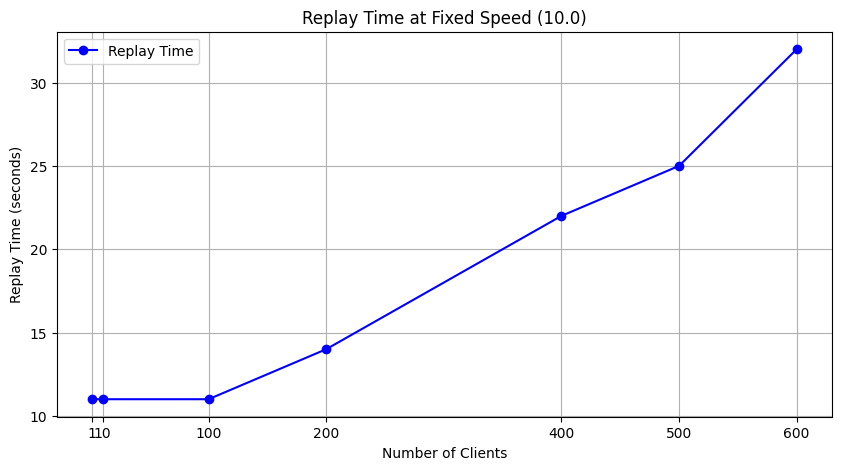

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample list of timestamps with format hh:mm:ss (time taken for requests)
times_in_seconds = [11, 11, 11, 14, 22, 25, 32]

# Generate the X-axis labels representing the number of clients (1, 2, 3, ...)
clients = [1, 10, 100, 200, 400, 500, 600]

# Plot the processing times per client
plt.figure(figsize=(10, 5))
plt.plot(clients, times_in_seconds, marker="o", linestyle="-", color="b", label="Replay Time")

# Format the plot
plt.xlabel("Number of Clients")
plt.ylabel("Replay Time (seconds)")
plt.title("Replay Time at Fixed Speed (10.0)")
plt.xticks(clients)  # Label X-axis with client numbers
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Suggestions for Improving Performance

- Run replay server and client on separate machines.
- Make sure network interfaces on test machines support high throughput.
- Carefully tune JVM and dependent libraries.
- Use binary wire encoding like Google Proto to reduce network traffic.
- Cache large datasets in a distributed cache like Redis.
- Horizontal scaling -> launch additional replay server processes with a Load Balancer to fan out traffic among the servers. Sticky connections would pin client traffic to the same server.

## Conclusion

As above tests demonstrate, replay server satisfies all the [Functional](#functional) and [Non-Functional](#non-functional) requirements.